# **Modèle de Popularité**

## **Imports et Dataframe**

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os

import sklearn

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, ConfusionMatrixDisplay, classification_report, f1_score, confusion_matrix

from xgboost import XGBRegressor

In [246]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [247]:
df = pd.read_csv('../data/data_110k_lignes.csv')

df.head(10)
df["track_id"].drop_duplicates(inplace=True)

In [248]:
col_drop = df.select_dtypes('object').columns.to_list()
col_drop.remove('genre')
df.drop(col_drop, axis=1, inplace=True)
df['explicit'] = df['explicit'].apply(lambda x : 0 if x == False else 1)
df['is_local'] = df['is_local'].apply(lambda x : 0 if x == False else 1)

df

,Unnamed: 0,popularity,duration_ms,explicit,is_local,track_number,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms.1,time_signature
0,0,66,230666,0,0,1,acoustic,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,230667,4
1,1,64,265843,0,0,1,acoustic,0.650,0.271,9,-11.081,1,0.0314,0.7940,0.000069,0.1960,0.2100,78.036,265843,4
2,2,53,180493,0,0,1,acoustic,0.758,0.722,1,-6.252,1,0.0511,0.1650,0.000006,0.1060,0.6600,146.031,180493,4
3,3,55,224333,0,0,4,acoustic,0.678,0.277,11,-10.537,1,0.0602,0.8430,0.000004,0.1040,0.2380,76.935,224333,4
4,4,54,215213,0,0,3,acoustic,0.566,0.733,4,-5.302,1,0.0699,0.0830,0.000002,0.3620,0.6360,178.828,215213,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110153,110153,3,308066,0,0,42,world-music,0.453,0.704,1,-4.620,1,0.0351,0.2260,0.000000,0.1180,0.2710,144.004,308067,4
110154,110154,5,230673,0,0,57,world-music,0.431,0.734,1,-4.561,1,0.0383,0.1210,0.000000,0.1040,0.3630,159.974,230673,4
110155,110155,5,339994,0,0,89,world-music,0.362,0.728,0,-8.105,1,0.0460,0.0270,0.000000,0.0681,0.0557,163.942,339994,4
110156,110156,4,198873,0,0,60,world-music,0.415,0.700,4,-6.059,1,0.0803,0.4520,0.000000,0.1560,0.5320,86.048,198873,4


In [249]:
df.dtypes

Unnamed: 0            int64
popularity            int64
duration_ms           int64
explicit              int64
is_local              int64
track_number          int64
genre                object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms.1         int64
time_signature        int64
dtype: object

In [250]:
transform = LabelEncoder()
df['genre'] = transform.fit_transform(df['genre'])

## **Découpage du dataset**

In [251]:
X = df.drop('popularity', axis=1)
y = df['popularity']

In [252]:
the_X_train, the_X_test, the_y_train, the_y_test = train_test_split(X, y, shuffle=True, stratify=X["genre"], train_size=0.95, random_state=42)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(the_X_train, the_y_train, shuffle=True, stratify=the_X_train["genre"], train_size=0.80, random_state=42)

In [254]:
dummy = DummyRegressor()

dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-5.6549251688853275e-05

## **Premier Modèle**

In [255]:
num_columns = [col for col in df.columns if df[col].dtype != "object"]
cat_columns = [col for col in df.columns if df[col].dtype == "object"]

std = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False)
label = LabelEncoder()

encoder = ColumnTransformer(
    transformers=[
        ('ohe', ohe, cat_columns)
    ],n_jobs=-1
)

In [256]:
models = [Lasso(), Ridge(), ElasticNet()]

In [257]:
list_models = []
dict_models_fit = {}

for model in models:
    pipe = Pipeline([
        # ('enc', encoder),
        ("std",std),
        ('poly', PolynomialFeatures(2)), 
        ('model', model),
    ])

    the_model = pipe.fit(X_train, y_train)
    dict_models_fit[f'{model.__class__.__name__}'] = the_model

    score = pipe.score(X_test, y_test)
    score = round(score,4)

    prediction = pipe.predict(X_test)
    score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
    score_mae = mean_absolute_error(y_test, prediction)

    list_models.append([f"{model.__class__.__name__}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])
    
    print(f"Nom du modèle : {model.__class__.__name__}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

Nom du modèle : Lasso, R2 score : 30.61%, RMSE score : 15.37, MAE : 12.64
Nom du modèle : Ridge, R2 score : 39.86%, RMSE score : 14.31, MAE : 11.51
Nom du modèle : ElasticNet, R2 score : 30.4%, RMSE score : 15.39, MAE : 12.67


In [258]:
df_list_models = pd.DataFrame(list_models,columns=['modele', "r2_score", "score_rmse"])

df_list_models.sort_values('r2_score', ascending=False)

,modele,r2_score,score_rmse
1,Ridge,39.86%,14.31
0,Lasso,30.61%,15.37
2,ElasticNet,30.4%,15.39


## **Évaluation**

In [259]:
model_entraines = []

In [260]:
def evaluation_ln(model):

    model.fit(X_train,y_train)
    prediction = model.predict(X_test)

    name = model.named_steps.model.__class__.__name__

    score = model.score(X_test, y_test)
    score = round(score,4)

    prediction = model.predict(X_test)
    score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
    score_mae = mean_absolute_error(y_test, prediction)

    list_models.append([f"{name}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])
    
    print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                n_jobs=-1,
                                                cv = 4, scoring='r2',
                                                train_sizes=np.linspace(0.1,1,10))
                                            
    model_entraines.append({'nom' : name, 'model': model, 'r2' : score})

    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='Train Score')
    plt.plot(N, val_score.mean(axis=1), label='Validation Score')
    plt.legend()
    plt.show()

In [261]:
def evaluation(model):

    model.fit(X_train,y_train)
    prediction = model.predict(X_test)

    name = model.named_steps.model.__class__.__name__

    score = model.score(X_test, y_test)
    score = round(score,4)

    prediction = model.predict(X_test)
    score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
    score_mae = mean_absolute_error(y_test, prediction)

    list_models.append([f"{model.__class__.__name__}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])
    
    print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

In [262]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

## **XgBoost**

In [263]:
for i in range(0, 3):
    pipe = Pipeline([
        # ('enc', encoder),
        ("std",std),
        ('poly', PolynomialFeatures(i)), 
        ('model', XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
    ])

    print('Range :', i)
    evaluation(pipe)

Range : 0
Nom du modèle : XGBRegressor, R2 score : -0.01%, RMSE score : 18.45, MAE : 15.29
Range : 1
Nom du modèle : XGBRegressor, R2 score : 89.51%, RMSE score : 5.97, MAE : 4.4
Range : 2
Nom du modèle : XGBRegressor, R2 score : 89.14%, RMSE score : 6.08, MAE : 4.52


Nom du modèle : XGBRegressor, R2 score : 89.51%, RMSE score : 5.97, MAE : 4.4


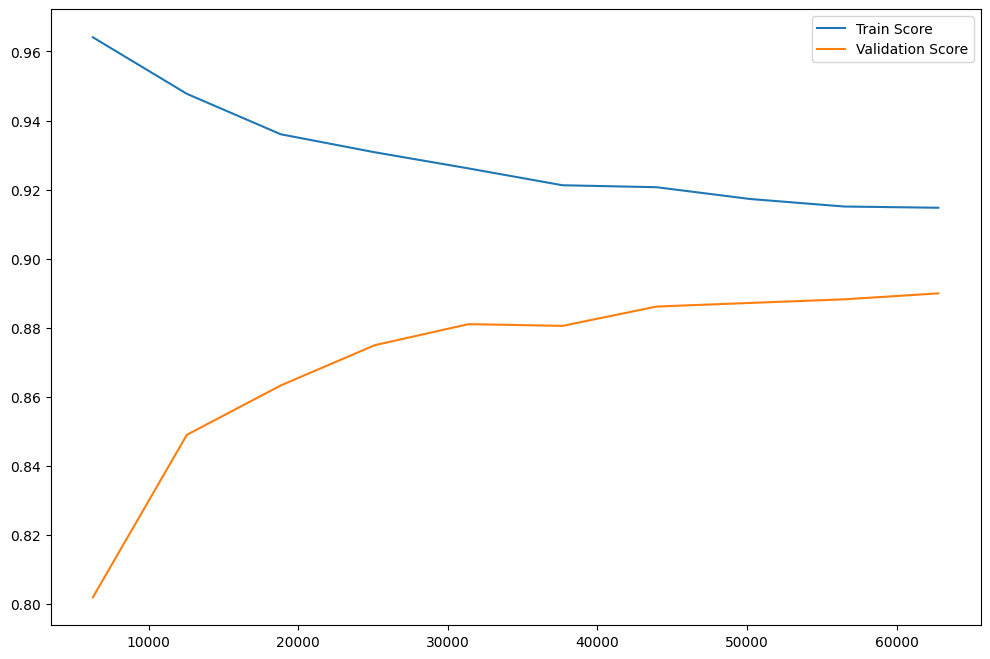

In [264]:
pipe = Pipeline([
    # ('enc', encoder),
    ("std",std),
    ('poly', PolynomialFeatures(1)), 
    ('model', XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
])

evaluation_ln(pipe)

## **RandomizedSearchCV**

In [204]:
pipe = Pipeline([
    # ('enc', encoder),
    ("std",std),
    ('poly', PolynomialFeatures(1)), 
    ('model', XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
])

param_grid = {
    'model__max_depth': [5, 10, 15, None],
    'model__learning_rate': list(np.linspace(0.1, 0.5, 6)),
    'model__n_estimators': list(range(40, 210, 10)),
    'model__gamma': list(np.linspace(0, 1, 5)) + [None],
}

grid = RandomizedSearchCV(pipe, param_grid, cv=4, scoring='r2', n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)

score = grid.best_score_
score = round(score,4)

params = grid.best_params_

print(f"Meilleur score : {round(score * 100, 2)}% \nMeilleurs paramètres : {params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END model__gamma=1.0, model__learning_rate=0.26, model__max_depth=5, model__n_estimators=80;, score=0.865 total time=   1.8s
[CV 4/4] END model__gamma=1.0, model__learning_rate=0.26, model__max_depth=5, model__n_estimators=80;, score=0.865 total time=   1.9s
[CV 3/4] END model__gamma=1.0, model__learning_rate=0.26, model__max_depth=5, model__n_estimators=80;, score=0.867 total time=   2.1s
[CV 2/4] END model__gamma=1.0, model__learning_rate=0.26, model__max_depth=5, model__n_estimators=80;, score=0.865 total time=   2.2s
[CV 2/4] END model__gamma=None, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=190;, score=0.884 total time=   3.9s
[CV 4/4] END model__gamma=None, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=190;, score=0.883 total time=   4.4s
[CV 1/4] END model__gamma=None, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=190;, score=0.883 total ti

Meilleur score : 90.27% 
Meilleurs paramètres : {'model__n_estimators': 160, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__gamma': 0.25}

Meilleur score : 88.66% 
Meilleurs paramètres : {'model__n_estimators': 200, 'model__max_depth': None, 'model__learning_rate': 0.1, 'model__gamma': None}

Meilleur score : 89.92% 
Meilleurs paramètres : {'model__n_estimators': 190, 'model__max_depth': 5, 'model__learning_rate': 0.26, 'model__gamma': 0.0}

Meilleur score : 89.26% 
Meilleurs paramètres : {'model__n_estimators': 200, 'model__max_depth': 10, 'model__learning_rate': 0.26, 'model__gamma': 0.75}

## **GridSearchCV**

In [208]:
pipe = Pipeline([
    # ('enc', encoder),
    ("std",std),
    ('poly', PolynomialFeatures(1)), 
    ('model', XGBRegressor(random_state=42, max_depth=10, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
])

param_grid = {
    'model__learning_rate': list(np.linspace(0.1, 0.3, 4)),
    'model__n_estimators': list(range(160, 260, 10)),
    'model__gamma': list(np.linspace(0, 1, 5)) + [None],
}

grid = GridSearchCV(pipe, param_grid, cv=4, scoring='r2', n_jobs=-1, verbose=3)

grid.fit(X_train, y_train)

score = grid.best_score_
score = round(score,4)

params = grid.best_params_

best_model = grid.best_estimator_

print(f"Meilleur score : {round(score * 100, 2)}% \nMeilleurs paramètres : {params}")

Fitting 4 folds for each of 240 candidates, totalling 960 fits
[CV 2/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.902 total time=  26.3s
[CV 2/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.902 total time=  26.5s
[CV 1/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.901 total time=  27.2s
[CV 3/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.905 total time=  27.5s
[CV 1/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.902 total time=  27.8s
[CV 4/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.902 total time=  30.3s
[CV 3/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.906 total time=  29.9s
[CV 4/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.903 total time=  30.9s
[CV 1/4] END model__gamma

Meilleur score : 90.7% 
Meilleurs paramètres : {'model__gamma': 0.25, 'model__learning_rate': 0.1, 'model__n_estimators': 250}

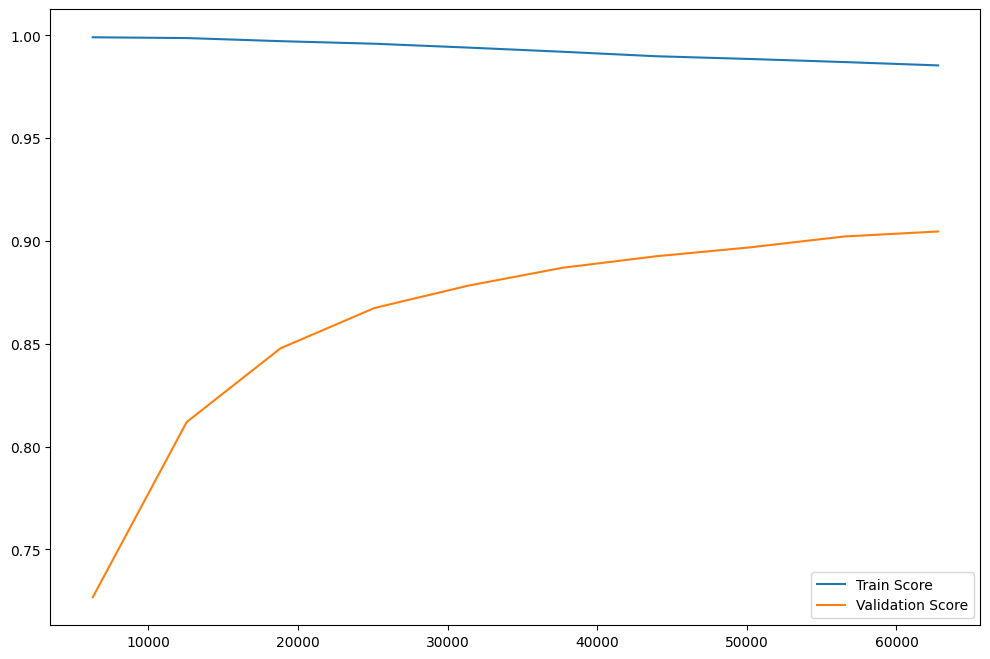

In [265]:
N, train_score, val_score = learning_curve(best_model, X_train, y_train,
                                            n_jobs=-1,
                                            cv = 4, scoring='r2',
                                            train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(12,8))
plt.plot(N, train_score.mean(axis=1), label='Train Score')
plt.plot(N, val_score.mean(axis=1), label='Validation Score')
plt.legend()
plt.show()

## **Test Final**

In [280]:
name = best_model[-1].__class__.__name__

score = best_model.score(X_test, y_test)
score = round(score,4)

prediction = best_model.predict(X_test)
score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
score_mae = mean_absolute_error(y_test, prediction)

print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

Nom du modèle : XGBRegressor, R2 score : 96.92%, RMSE score : 3.24, MAE : 2.15


In [281]:
name = best_model[-1].__class__.__name__

score = best_model.score(the_X_test, the_y_test)
score = round(score,4)

prediction = best_model.predict(the_X_test)
score_rmse = math.sqrt(mean_squared_error(the_y_test, prediction))
score_mae = mean_absolute_error(the_y_test, prediction)

print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

Nom du modèle : XGBRegressor, R2 score : 90.77%, RMSE score : 5.63, MAE : 3.97


## **MLFlow**

In [209]:
import mlflow

In [210]:
experiment_name = "Brief"

In [211]:
try:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
except AttributeError:
    experiment_id = mlflow.create_experiment(experiment_name)

eval_data = X_test
eval_data["label"] = y_test

with mlflow.start_run(experiment_id=experiment_id, nested=True, run_name=best_model[-1].__class__.__name__):
    mlflow.log_params(best_model[-1].get_params())
    mlflow.sklearn.log_model(best_model, experiment_name)
    model_uri = mlflow.get_artifact_uri(experiment_name)

    result = mlflow.evaluate(
            model_uri,
            eval_data,
            targets="label",
            model_type="regressor",
            evaluators=["default"],
    )

2023/02/28 22:18:14 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/02/28 22:18:15 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
Permutation explainer: 2001it [06:42,  4.90it/s]                          
Unable to serialize underlying model using MLflow, will use SHAP serialization
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
